# Tutorial: PyTorch Code Walkthrough + a small Demo

We’ll focus on the three practical takeaways in PyTorch’s nn.MultiheadAttention, then run a tiny demo to interpret attention maps.



## PyTorch `nn.MultiheadAttention` Implementation


Source (pytorch/torch/nn/modules/activation.py):
- https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/activation.py#L1089-L1566

### Three engineering takeaways
1) Supporting both input layouts: `(batch, seq, dim)` and `(seq, batch, dim)`.
2) `need_weights` indirectly controls whether PyTorch uses the regular math implementation or CUDA-optimized SDPA kernels.
3) Supporting three masking controls: `key_padding_mask`, `attn_mask`, and `is_causal`.

**For a full look at how these are implemented (in `F.multi_head_attention_forward`), see `f_mha_key.ipynb`.**

In [ ]:
class MultiheadAttention(Module):
    # ...
    __constants__ = ["batch_first"]
    bias_k: torch.Tensor | None
    bias_v: torch.Tensor | None

    def __init__(
        self,
        embed_dim,
        num_heads,
        dropout=0.0,
        bias=True,
        add_bias_kv=False,
        add_zero_attn=False,
        kdim=None,
        vdim=None,
        batch_first=False,
        device=None,
        dtype=None,
    ) -> None:
        if embed_dim <= 0 or num_heads <= 0:
            raise ValueError(
                f"embed_dim and num_heads must be greater than 0,"
                f" got embed_dim={embed_dim} and num_heads={num_heads} instead"
            )
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_first = batch_first
        self.head_dim = embed_dim // num_heads
        if self.head_dim * num_heads != self.embed_dim:
            raise AssertionError("embed_dim must be divisible by num_heads")

        if not self._qkv_same_embed_dim:
            # ...
        else:
            self.in_proj_weight = Parameter(
                torch.empty((3 * embed_dim, embed_dim), **factory_kwargs)
            )
            self.register_parameter("q_proj_weight", None)
            self.register_parameter("k_proj_weight", None)
            self.register_parameter("v_proj_weight", None)


        if bias:
            self.in_proj_bias = Parameter(torch.empty(3 * embed_dim, **factory_kwargs))
        else:
            self.register_parameter("in_proj_bias", None)
        self.out_proj = NonDynamicallyQuantizableLinear(
            embed_dim, embed_dim, bias=bias, **factory_kwargs
        )

        if add_bias_kv:
            self.bias_k = Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
            self.bias_v = Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
        else:
            self.bias_k = self.bias_v = None


        self.add_zero_attn = add_zero_attn

        self._reset_parameters()

    def _reset_parameters(self) -> None:
        if self._qkv_same_embed_dim:
            xavier_uniform_(self.in_proj_weight)
        else:
            # ...

        if self.in_proj_bias is not None:
            constant_(self.in_proj_bias, 0.0)
            constant_(self.out_proj.bias, 0.0)
        if self.bias_k is not None:
            xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            xavier_normal_(self.bias_v)


    def forward(
        self,
        query: Tensor,
        key: Tensor,
        value: Tensor,
        key_padding_mask: Tensor | None = None,
        need_weights: bool = True,
        attn_mask: Tensor | None = None,
        average_attn_weights: bool = True,
        is_causal: bool = False,
    ) -> tuple[Tensor, Tensor | None]:
        # ...
        is_batched = query.dim() == 3
        
        key_padding_mask = F._canonical_mask()
        attn_mask = F._canonical_mask()

        if self.batch_first and is_batched:
            # ...
            query = key = value = query.transpose(1, 0)
            # ...

        if not self._qkv_same_embed_dim:
            attn_output, attn_output_weights = F.multi_head_attention_forward(
                query,
                key,
                value,
                self.embed_dim,
                self.num_heads,
                self.in_proj_weight,
                self.in_proj_bias,
                self.bias_k,
                self.bias_v,
                self.add_zero_attn,
                self.dropout,
                self.out_proj.weight,
                self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask,
                need_weights=need_weights,
                attn_mask=attn_mask,
                use_separate_proj_weight=True,
                q_proj_weight=self.q_proj_weight,
                k_proj_weight=self.k_proj_weight,
                v_proj_weight=self.v_proj_weight,
                average_attn_weights=average_attn_weights,
                is_causal=is_causal,
            )
        else:
            attn_output, attn_output_weights = F.multi_head_attention_forward(
                query,
                key,
                value,
                self.embed_dim,
                self.num_heads,
                self.in_proj_weight,
                self.in_proj_bias,
                self.bias_k,
                self.bias_v,
                self.add_zero_attn,
                self.dropout,
                self.out_proj.weight,
                self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask,
                need_weights=need_weights,
                attn_mask=attn_mask,
                average_attn_weights=average_attn_weights,
                is_causal=is_causal,
            )
        if self.batch_first and is_batched:
            return attn_output.transpose(1, 0), attn_output_weights
        else:
            return attn_output, attn_output_weights

## A Quick DEMO

1) Build a dataset where each sentence contains the word "bank", along with contextual cues indicating whether it refers to a riverbank or financialbank. Random filler and confuser words are added to increase difficulty.

In [58]:
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

set_seed(42)
torch.set_num_threads(min(4, os.cpu_count() or 1))
device = torch.device("cpu")

# -------------------------
# 1) "Normal sentence" templates (semantics-driven, not position rule)
# -------------------------
RIVER_CUES = ["river", "water", "boat", "fish", "shore", "stream"]
MONEY_CUES = ["money", "loan", "deposit", "account", "credit", "cash", "interest"]

FILLERS = ["the","a","near","beside","around","today","bright","cloudy","people","trees","city","news","quickly","slowly","small","large","old","new"]

# River sense templates
RIVER_TEMPLATES = [
    "the {river} is near the bank",
    "the boat is on the {river} by the bank",
    "fish swim in the {river} near the bank",
    "water from the {river} reaches the bank",
    "the {river} flows past the bank",
    "trees stand by the bank of the {river}",
]

# Financial sense templates
FIN_TEMPLATES = [
    "the bank approved the {loan}",
    "i deposit money in the bank {account}",
    "the bank offers {credit} to customers",
    "the bank handles cash and {loan}",
    "the bank charges {interest} on the loan",
    "customers open an account at the bank",
]

def add_fillers(tokens, max_extra=4):
    """Insert some filler words at random positions."""
    t = tokens[:]
    k = random.randint(0, max_extra)
    for _ in range(k):
        w = random.choice(FILLERS)
        pos = random.randrange(len(t) + 1)
        t.insert(pos, w)
    return t

def maybe_add_confuser(tokens, label, p=0.35):
    """
    Optional: add a confuser cue from the opposite sense as noise.
    Crucially: do it symmetrically so it doesn't become a label shortcut.
    """
    if random.random() > p:
        return tokens
    conf = random.choice(MONEY_CUES if label == 0 else RIVER_CUES)
    t = tokens[:]
    pos = random.randrange(len(t) + 1)
    t.insert(pos, conf)
    return t

def make_sentence(label):
    if label == 0:
        # riverbank
        tpl = random.choice(RIVER_TEMPLATES)
        sent = tpl.format(
            river=random.choice(["river","stream"]),
        )
    else:
        # financial
        tpl = random.choice(FIN_TEMPLATES)
        sent = tpl.format(
            loan=random.choice(["loan","credit"]),
            account=random.choice(["account"]),
            credit=random.choice(["credit"]),
            interest=random.choice(["interest"]),
        )

    tokens = sent.lower().split()

    # add symmetric fillers + (optional) symmetric confuser noise
    tokens = add_fillers(tokens, max_extra=4)
    tokens = maybe_add_confuser(tokens, label, p=0.35)

    # sanity: ensure 'bank' exists
    assert "bank" in tokens
    return tokens

# Build dataset
N = 2000
tokenized = []
labels = []
for i in range(N):
    y = i % 2  # balanced
    toks = make_sentence(y)
    tokenized.append(toks)
    labels.append(y)

# vocab
vocab = {"[PAD]": 0}
for w in sorted({t for toks in tokenized for t in toks}):
    vocab[w] = len(vocab)
ivocab = {i:w for w,i in vocab.items()}

max_len = max(len(toks) for toks in tokenized)

def encode(tokens):
    ids = [vocab[t] for t in tokens]
    return ids + [0] * (max_len - len(ids))

x = torch.tensor([encode(toks) for toks in tokenized], dtype=torch.long, device=device)
y = torch.tensor(labels, dtype=torch.long, device=device)
bank_idx = torch.tensor([toks.index("bank") for toks in tokenized], dtype=torch.long, device=device)
pad_mask = (x == 0)

# train/test split
n_test = int(0.2 * N)
x_train, y_train, b_train, pm_train = x[:-n_test], y[:-n_test], bank_idx[:-n_test], pad_mask[:-n_test]
x_test,  y_test,  b_test,  pm_test  = x[-n_test:],  y[-n_test:],  bank_idx[-n_test:],  pad_mask[-n_test:]


2) Define a single-layer multi-head self-attention classifier and train it for 10 epochs.

In [ ]:
# -------------------------
# 2) Attention-only model
# -------------------------
class BankSenseSelfAttention(nn.Module):
    def __init__(self, vocab_size, d_model=64, num_heads=4, max_len=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos   = nn.Embedding(max_len, d_model)
        self.attn  = nn.MultiheadAttention(d_model, num_heads, dropout=0.0, batch_first=True)
        self.cls   = nn.Linear(d_model, 2)

    def forward(self, x, bank_idx, key_padding_mask=None, need_weights=True):
        B, T = x.shape
        pos_ids = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
        h = self.embed(x) + self.pos(pos_ids)

        out, attn_w = self.attn(
            h, h, h,
            key_padding_mask=key_padding_mask,
            need_weights=need_weights,
            average_attn_weights=False
        )
        z = out[torch.arange(B, device=x.device), bank_idx]
        logits = self.cls(z)
        return logits, attn_w

model = BankSenseSelfAttention(len(vocab), d_model=64, num_heads=4, max_len=max_len).to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-3)

# -------------------------
# 3) Train 
# -------------------------
bs = 128
for ep in range(1, 51):
    model.train()
    perm = torch.randperm(x_train.size(0), device=device)
    for i in range(0, x_train.size(0), bs):
        idx = perm[i:i+bs]
        logits, _ = model(x_train[idx], b_train[idx], key_padding_mask=pm_train[idx], need_weights=False)
        loss = F.cross_entropy(logits, y_train[idx])
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        tr = model(x_train, b_train, key_padding_mask=pm_train, need_weights=False)[0].argmax(-1)
        te = model(x_test,  b_test,  key_padding_mask=pm_test,  need_weights=False)[0].argmax(-1)
    #print(f"ep {ep:02d} | train acc {(tr==y_train).float().mean().item():.3f} | test acc {(te==y_test).float().mean().item():.3f}")
print('Done')


Done


3) Visualise the attention weights (the *bank* query row) as heatmaps to see which context words each head attends to.

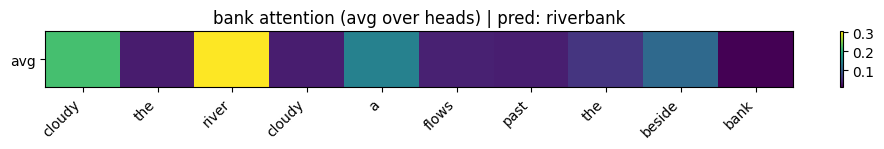

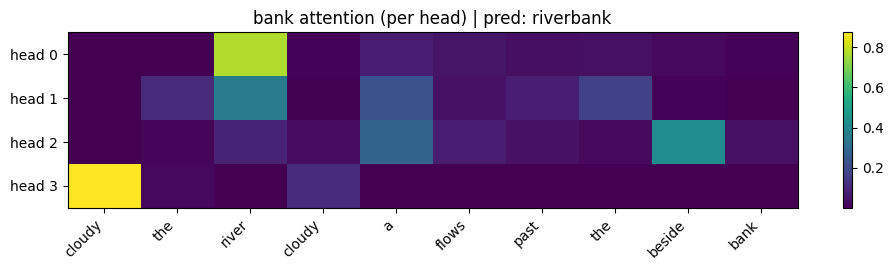

sentence: cloudy the river cloudy a flows past the beside bank
prediction: riverbank


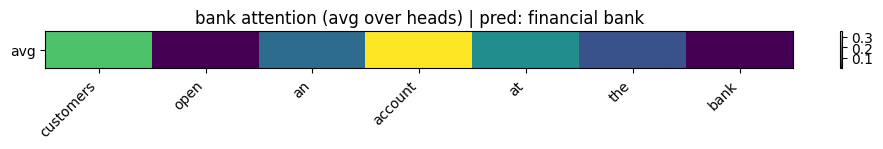

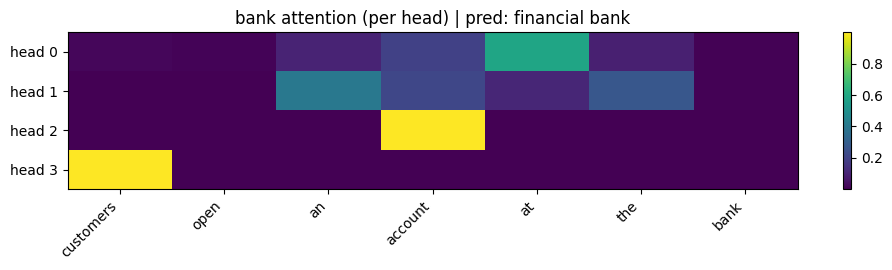

sentence: customers open an account at the bank
prediction: financial bank


In [62]:
# -------------------------
# 4) Heatmap: bank row (per head + averaged row)
# -------------------------
id_to_label = {0:"riverbank", 1:"financial bank"}

def show_bank_attention(tokens):
    ids = [vocab[t] for t in tokens] + [0]*(max_len - len(tokens))
    x1 = torch.tensor([ids], dtype=torch.long, device=device)
    pm = (x1 == 0)
    bpos = torch.tensor([tokens.index("bank")], dtype=torch.long, device=device)

    model.eval()
    with torch.no_grad():
        logits, attn_w = model(x1, bpos, key_padding_mask=pm, need_weights=True)
    pred = int(logits.argmax(-1).item())

    # attn_w: [1, heads, T, T] -> take bank query row
    T = len(tokens)
    bank_row = attn_w[0, :, bpos.item(), :T].detach().cpu().numpy()  # [heads, T]
    bank_avg = bank_row.mean(axis=0, keepdims=True)                 # [1, T]

    # Plot averaged row (more readable) + per-head
    plt.figure(figsize=(10, 1.6))
    plt.imshow(bank_avg, aspect="auto", interpolation="nearest")
    plt.yticks([0], ["avg"])
    plt.xticks(range(T), tokens, rotation=45, ha="right")
    plt.colorbar()
    plt.title(f"bank attention (avg over heads) | pred: {id_to_label[pred]}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 2.8))
    plt.imshow(bank_row, aspect="auto", interpolation="nearest")
    plt.yticks(range(bank_row.shape[0]), [f"head {i}" for i in range(bank_row.shape[0])])
    plt.xticks(range(T), tokens, rotation=45, ha="right")
    plt.colorbar()
    plt.title(f"bank attention (per head) | pred: {id_to_label[pred]}")
    plt.tight_layout()
    plt.show()

    print("sentence:", " ".join(tokens))
    print("prediction:", id_to_label[pred])

# show one example each (from test set)
with torch.no_grad():
    preds = model(x_test, b_test, key_padding_mask=pm_test, need_weights=False)[0].argmax(-1).cpu().tolist()
y_true = y_test.cpu().tolist()
test_tokens = tokenized[-n_test:]

river_i = next(i for i,(p,t) in enumerate(zip(preds,y_true)) if t==0)
fin_i   = next(i for i,(p,t) in enumerate(zip(preds,y_true)) if t==1)

show_bank_attention(test_tokens[river_i])
show_bank_attention(test_tokens[fin_i])
